In [116]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

In [117]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Preliminary Analysis to Understand the Data

In [118]:
file = '/content/drive/MyDrive/Nafas/nafas2.csv'

df = pd.read_csv(file, encoding='UTF-16', sep='\t')
df.head()

<ipython-input-118-b2a4d892094f>:3: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file, encoding='UTF-16', sep='\t')


,Member Uuid,Room Name,Device Name,Timestamp,Mode,Pm25,Power,Speed
0,1f8a0dd4-72c2-4ff4-bfb9-8b8ded756ec5,NaN,Pure40_22f023,1/11/2024 00.00,AUTO,NaN,NaN,NaN
1,1f8a0dd4-72c2-4ff4-bfb9-8b8ded756ec5,NaN,Pure40_22f023,1/11/2024 00.01,AUTO,NaN,NaN,NaN
2,1f8a0dd4-72c2-4ff4-bfb9-8b8ded756ec5,NaN,Pure40_22f023,1/11/2024 00.02,AUTO,NaN,NaN,NaN
3,1f8a0dd4-72c2-4ff4-bfb9-8b8ded756ec5,NaN,Pure40_22f023,1/11/2024 00.03,AUTO,NaN,NaN,NaN
4,1f8a0dd4-72c2-4ff4-bfb9-8b8ded756ec5,NaN,Pure40_22f023,1/11/2024 00.04,AUTO,NaN,NaN,NaN


In [119]:
df = df.rename(columns={'Member Uuid': 'Uuid'})

In [120]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048573 entries, 0 to 1048572
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Uuid         1048573 non-null  object 
 1   Room Name    617058 non-null   object 
 2   Device Name  1048573 non-null  object 
 3   Timestamp    1048573 non-null  object 
 4   Mode         869183 non-null   object 
 5   Pm25         577353 non-null   float64
 6   Power        577353 non-null   float64
 7   Speed        397963 non-null   float64
dtypes: float64(3), object(5)
memory usage: 64.0+ MB


In [138]:
df.describe()

,Timestamp,Pm25,Power,Speed
count,1048573,577353.000000,577353.000000,397963.000000
mean,2024-09-13 22:35:07.193032704,14.974667,0.720810,0.866550
min,2024-01-11 00:00:00,0.000000,0.000000,0.000000
25%,2024-07-11 13:31:00,2.000000,0.000000,0.000000
50%,2024-11-14 21:01:00,7.000000,1.000000,1.000000
75%,2024-11-22 22:32:00,20.000000,1.000000,1.000000
max,2024-12-11 23:59:00,2000.000000,1.000000,8.000000
std,NaN,39.659187,0.448601,0.971502


In [122]:
df['Uuid'].unique()

array(['1f8a0dd4-72c2-4ff4-bfb9-8b8ded756ec5',
       '2dd89330-253f-4659-90cc-55ee33bcdb38',
       '2e13b5a2-99eb-4277-a51b-d37c765a0a2e',
       '2f04498d-3408-4bd9-a545-653364db22fa',
       '4c5f4c12-a85f-46e8-b075-b58e63b7bf71',
       '5ab22bb7-c837-4703-acf6-b9137820d670',
       '5d5c95ae-47d0-4194-b0d0-d2a29b6cd3f8'], dtype=object)

In [123]:
df['Timestamp'] = df['Timestamp'].str.replace('.', ':', regex=False)
# Parse as datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'], format='mixed')

df['Power'] = df['Power'].apply(lambda x: 1 if x >= 2 else x)

# 3. Extract device type from Device Name
df['device_type'] = df['Device Name'].str.split('_').str[0]

# 4. Split into device-specific DataFrames
pure40_df = df[df['device_type'] == 'Pure40'].copy()
pure60_df = df[df['device_type'] == 'Pure60'].copy()
airtest_df = df[df['device_type'] == 'AirTest'].copy()

purifier_df = pd.concat([pure40_df, pure60_df], ignore_index=True)

# Filter out rows from Pure60 devices where Mode = 'MANUAL'
purifier_df = pd.concat([
    purifier_df[purifier_df['device_type'] != 'Pure60'],  # Keep all non-Pure60 devices
    purifier_df[(purifier_df['device_type'] == 'Pure60') & (purifier_df['Mode'] == 'OFF')]  # Only keep Pure60 with Mode != 'MANUAL'
], ignore_index=True)

pure60_df = purifier_df[(pure60_df['device_type'] == 'Pure60') & (purifier_df['Mode'] == 'OFF')]  # Only keep Pure60 with Mode != 'MANUAL'

# Check the effect of our filtering
pure60_count = len(purifier_df[purifier_df['device_type'] == 'Pure60'])
print(f"Remaining Pure60 rows after filtering: {pure60_count}")

# Check unique Mode values for Pure60 devices
modes = purifier_df[purifier_df['device_type'] == 'Pure60']['Mode'].unique()
print(f"Remaining modes for Pure60: {modes}")



Remaining Pure60 rows after filtering: 21961
Remaining modes for Pure60: ['OFF']


7 users

In [124]:
import pandas as pd

def clean_purifier_data(df):
    """Clean Power column based on Mode and handle outliers"""
    df = df.copy()

    # Rule 1: Set Power=0 when Mode is OFF
    df.loc[df['Mode'] == 'OFF', 'Power'] = 0

    # Rule 2: Set Power=1 for AUTO/MANUAL modes
    df.loc[df['Mode'].isin(['AUTO', 'MANUAL']), 'Power'] = 1

    # Rule 3: Cap Power values at 1
    df.loc[df['Power'] > 1, 'Power'] = 1

    # Convert to integer (0/1)
    df['Power'] = df['Power'].astype('Int8')  # Uses pandas' nullable integer type

    return df
pure60 = clean_purifier_data(pure60_df)
pure40 = clean_purifier_data(pure40_df)
purifier_df = clean_purifier_data(purifier_df)

print("\n=== Purifier Power Value Counts ===")
print(purifier_df['Power'].value_counts(dropna=False))



=== Purifier Power Value Counts ===
Power
1    519919
0    327303
Name: count, dtype: Int64


In [125]:
print("=== AirTest Dataset ===")
print(f"Rows: {len(airtest_df)} | Columns: {airtest_df.columns.tolist()}")

print("\n=== Purifier Dataset ===")
print(f"Rows: {len(purifier_df)} | Columns: {purifier_df.columns.tolist()}")

=== AirTest Dataset ===
Rows: 179390 | Columns: ['Uuid', 'Room Name', 'Device Name', 'Timestamp', 'Mode', 'Pm25', 'Power', 'Speed', 'device_type']

=== Purifier Dataset ===
Rows: 847222 | Columns: ['Uuid', 'Room Name', 'Device Name', 'Timestamp', 'Mode', 'Pm25', 'Power', 'Speed', 'device_type']


In [126]:
print(purifier_df['Mode'].value_counts())

Mode
OFF       327303
MANUAL    279738
AUTO      240181
Name: count, dtype: int64


In [127]:
pure60['Mode'].unique()

array(['OFF'], dtype=object)

# Purifier Usage Analysis

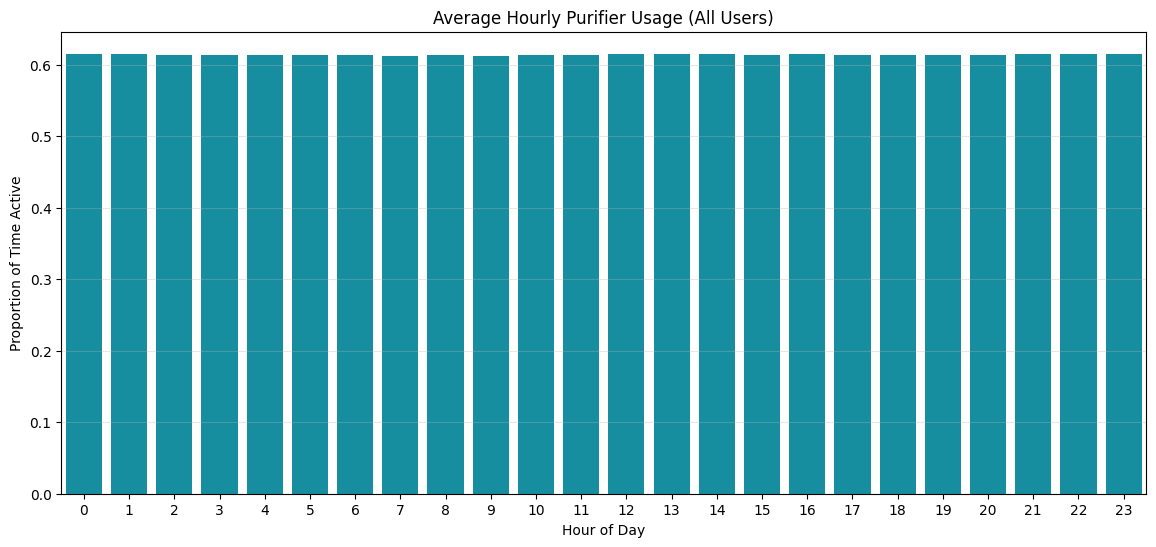

In [128]:
# --------------------------
# 1. Create Time-Based Features
# --------------------------
def add_time_features(df):
    """Add hour, date, weekday, and weekend features"""
    df = df.copy()
    df['hour'] = df['Timestamp'].dt.hour
    df['date'] = df['Timestamp'].dt.date
    df['day_of_week'] = df['Timestamp'].dt.dayofweek  # Monday=0, Sunday=6
    df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)
    return df

# Apply to all relevant DataFrames
purifier_df = add_time_features(purifier_df)
pure40 = add_time_features(pure40)
pure60 = add_time_features(pure60)
airtest_df = add_time_features(airtest_df)

# --------------------------
# 2. Calculate Usage Metrics
# --------------------------
def calculate_usage_metrics(df):
    """Add metrics for analysis"""
    df = df.copy()
    # Daily active hours (assuming 1 row per minute)
    df['is_active'] = df['Power'].apply(lambda x: 1 if x > 0 else 0)
    return df

purifier_df = calculate_usage_metrics(purifier_df)
# pure40 = calculate_usage_metrics(pure40)
# pure60 = calculate_usage_metrics(pure60)

# --------------------------
# 3. First Key Visualization
# --------------------------
# Hourly usage patterns for all purifiers
plt.figure(figsize=(14,6))
sns.barplot(
    data=purifier_df.groupby('hour')['is_active'].mean().reset_index(),
    x='hour',
    y='is_active',
    color='#009FB7'
)
plt.title('Average Hourly Purifier Usage (All Users)')
plt.xlabel('Hour of Day')
plt.ylabel('Proportion of Time Active')
plt.xticks(range(0,24))
plt.grid(axis='y', alpha=0.3)
plt.show()


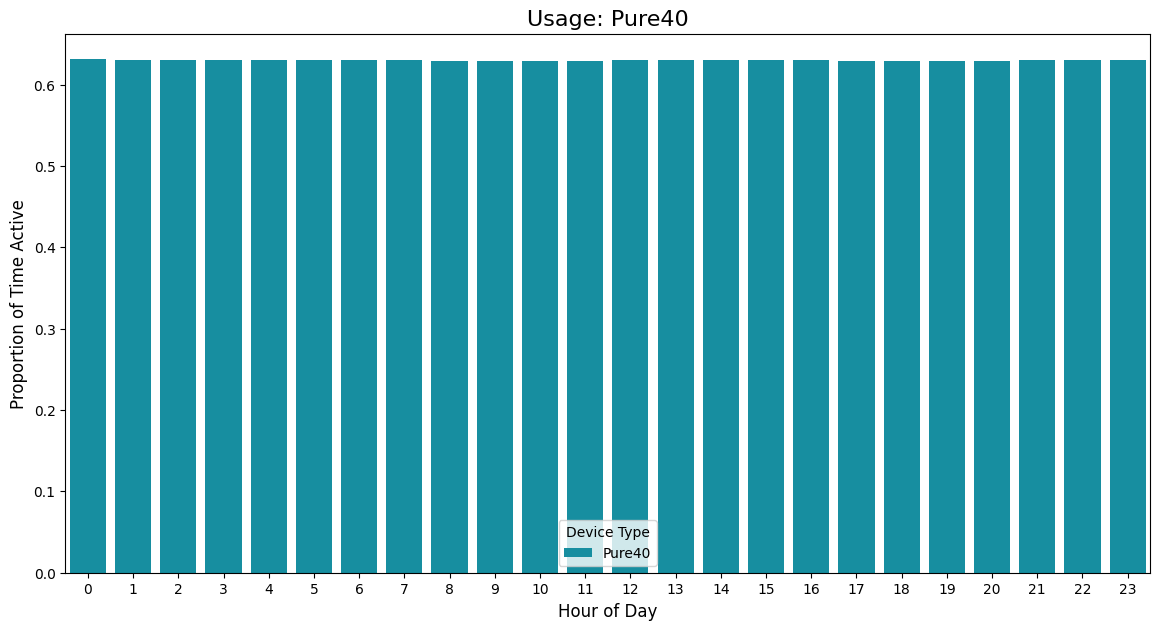

In [129]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create time-based features for comparison
def add_hourly_usage(df):
    df['hour'] = df['Timestamp'].dt.hour
    df['is_active'] = df['Power'].apply(lambda x: 1 if x > 0 else 0)
    return df

pure40 = add_hourly_usage(pure40.copy())
pure60 = add_hourly_usage(pure60.copy())

# Calculate hourly usage
pure40_hourly = pure40.groupby('hour')['is_active'].mean().reset_index()
# pure60_hourly = pure60.groupby('hour')['is_active'].mean().reset_index()

# Create a DataFrame for side-by-side plotting
comparison_df = pd.DataFrame({
    'hour': pure40_hourly['hour'],
    'Pure40': pure40_hourly['is_active'],
    # 'Pure60': pure60_hourly['is_active']
})
comparison_df = comparison_df.melt(id_vars=['hour'], var_name='device', value_name='usage')

plt.figure(figsize=(14,7))
sns.barplot(data=comparison_df, x='hour', y='usage', hue='device',
            palette={'Pure40': '#009FB7'})
plt.title('Usage: Pure40', fontsize=16)
plt.xlabel('Hour of Day', fontsize=12)
plt.ylabel('Proportion of Time Active', fontsize=12)
plt.legend(title='Device Type')
plt.show()




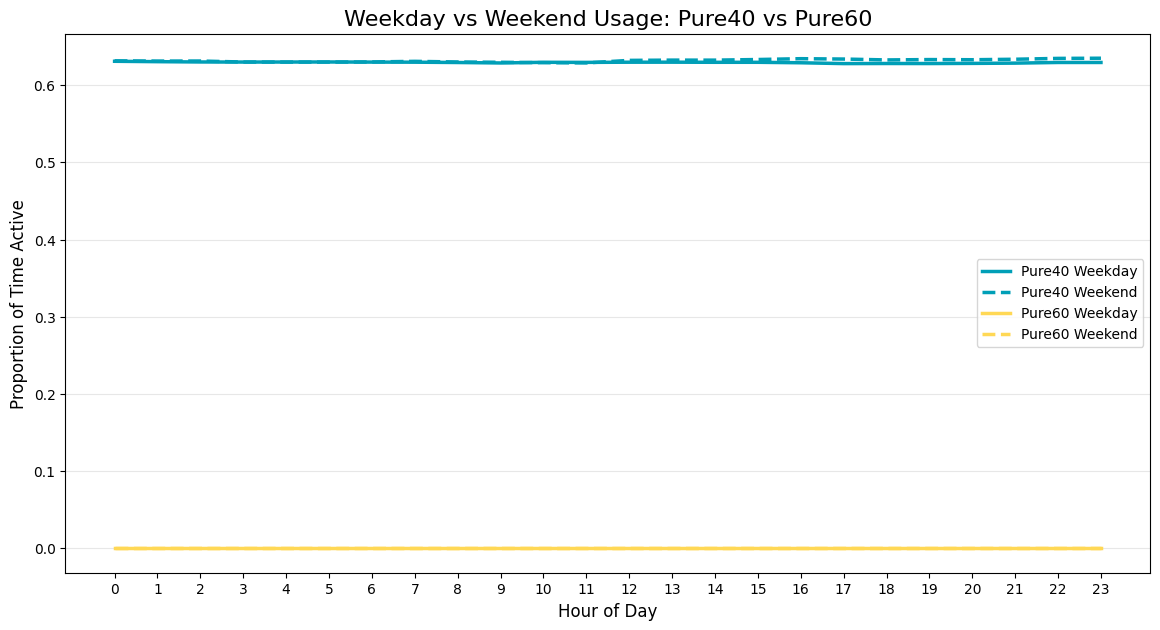

In [130]:
# Add weekday/weekend distinction
pure40['is_weekend'] = pure40['Timestamp'].dt.dayofweek >= 5
pure60['is_weekend'] = pure60['Timestamp'].dt.dayofweek >= 5

# Calculate hourly usage broken down by weekday/weekend
pure40_hourly_split = pure40.groupby(['hour', 'is_weekend'])['is_active'].mean().unstack()
pure60_hourly_split = pure60.groupby(['hour', 'is_weekend'])['is_active'].mean().unstack()

# Plot with 4 lines (Pure40 weekday, Pure40 weekend, Pure60 weekday, Pure60 weekend)
plt.figure(figsize=(14,7))
plt.plot(pure40_hourly_split.index, pure40_hourly_split[False],
         color='#009FB7', linewidth=2.5, label='Pure40 Weekday')
plt.plot(pure40_hourly_split.index, pure40_hourly_split[True],
         color='#009FB7', linewidth=2.5, linestyle='--', label='Pure40 Weekend')
plt.plot(pure60_hourly_split.index, pure60_hourly_split[False],
         color='#FFD855', linewidth=2.5, label='Pure60 Weekday')
plt.plot(pure60_hourly_split.index, pure60_hourly_split[True],
         color='#FFD855', linewidth=2.5, linestyle='--', label='Pure60 Weekend')
plt.title('Weekday vs Weekend Usage: Pure40 vs Pure60', fontsize=16)
plt.xlabel('Hour of Day', fontsize=12)
plt.ylabel('Proportion of Time Active', fontsize=12)
plt.xticks(range(0,24))
plt.grid(axis='y', alpha=0.3)
plt.legend()
plt.show()


<Figure size 1000x600 with 0 Axes>

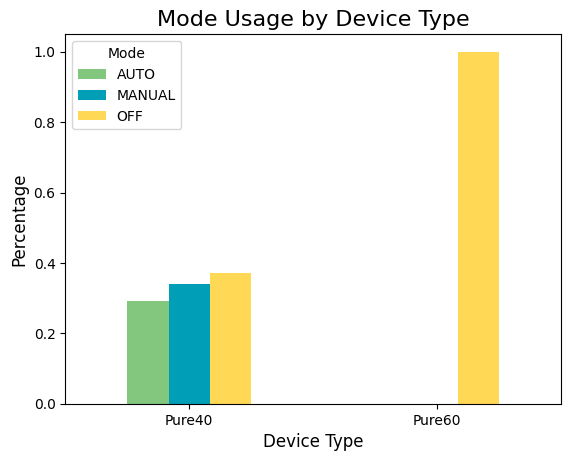

In [131]:
# Calculate AUTO vs MANUAL vs OFF proportions by device type
mode_by_device = pd.crosstab(
    purifier_df['device_type'],
    purifier_df['Mode'],
    normalize='index'
)

# Plot as a grouped bar chart
plt.figure(figsize=(10,6))
mode_by_device.plot(kind='bar', color=['#83c77f', '#009FB7', '#FFD855'])
plt.title('Mode Usage by Device Type', fontsize=16)
plt.xlabel('Device Type', fontsize=12)
plt.ylabel('Percentage', fontsize=12)
plt.xticks(rotation=0)
plt.legend(title='Mode')
plt.show()


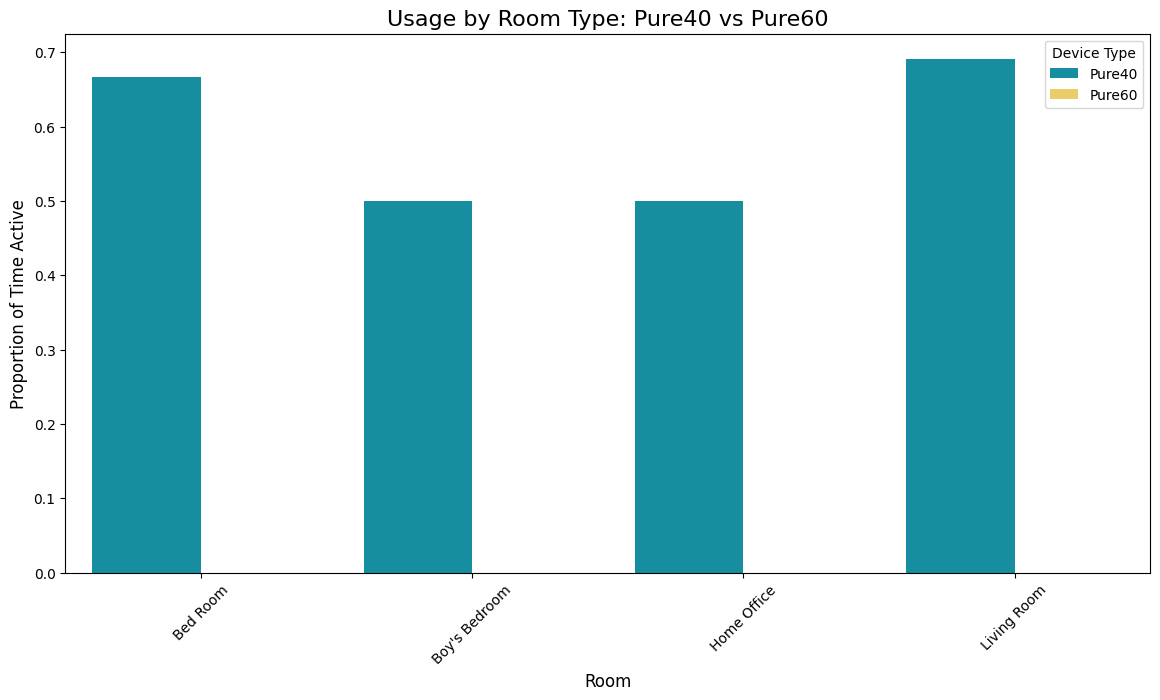

In [132]:
# Check if room data is available
plt.figure(figsize=(14,7))
sns.barplot(
    data=pd.concat([
        pure40.groupby('Room Name')['Power'].mean().reset_index().assign(device='Pure40'),
        pure60.groupby('Room Name')['Power'].mean().reset_index().assign(device='Pure60')
    ]),
    x='Room Name', y='Power', hue='device',
    palette={'Pure40': '#009FB7', 'Pure60': '#FFD855'}
)
plt.title('Usage by Room Type: Pure40 vs Pure60', fontsize=16)
plt.xlabel('Room', fontsize=12)
plt.ylabel('Proportion of Time Active', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Device Type')
plt.show()


In [133]:
purifier_df['Uuid'].unique()

array(['1f8a0dd4-72c2-4ff4-bfb9-8b8ded756ec5',
       '2e13b5a2-99eb-4277-a51b-d37c765a0a2e',
       '2f04498d-3408-4bd9-a545-653364db22fa',
       '4c5f4c12-a85f-46e8-b075-b58e63b7bf71',
       '5ab22bb7-c837-4703-acf6-b9137820d670',
       '2dd89330-253f-4659-90cc-55ee33bcdb38'], dtype=object)

# pm2.5 ANALYSIS

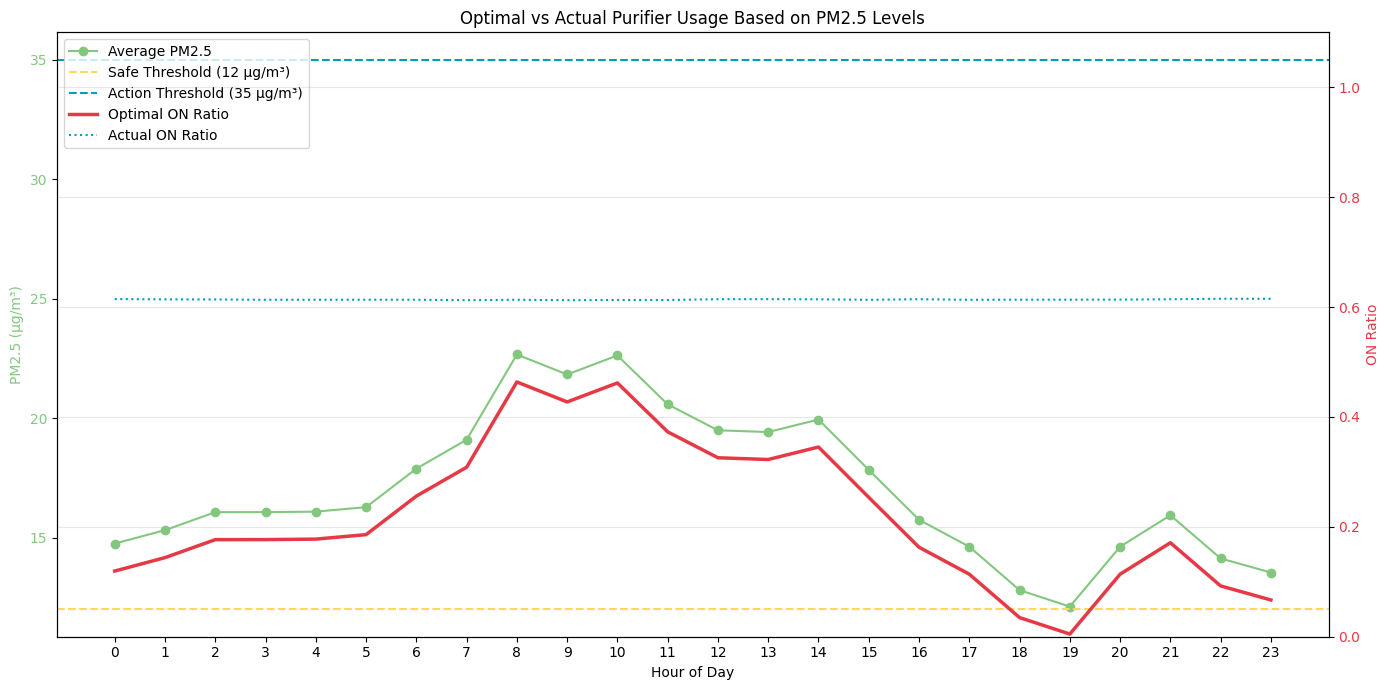

In [137]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# --------------------------
# 1. Prepare Combined PM2.5 Data
# --------------------------
def get_combined_pm25(purifier_df, airtest_df):
    # Get AirTest PM2.5 from all users
    airtest_pm25 = airtest_df.groupby(pd.to_datetime(airtest_df['Timestamp']).dt.hour)['Pm25'].mean().reset_index()
    airtest_pm25.columns = ['hour', 'pm25_airtest']

    # Get Purifier PM2.5 (where available)
    purifier_pm25 = purifier_df[purifier_df['Pm25'].notnull()]
    purifier_pm25 = purifier_pm25.groupby(pd.to_datetime(purifier_pm25['Timestamp']).dt.hour)['Pm25'].mean().reset_index()
    purifier_pm25.columns = ['hour', 'pm25_purifier']

    # Combine and average
    combined = pd.merge(airtest_pm25, purifier_pm25, on='hour', how='outer')
    combined['pm25_avg'] = combined[['pm25_airtest', 'pm25_purifier']].mean(axis=1)
    return combined[['hour', 'pm25_avg']].dropna()

# --------------------------
# 2. Calculate Optimal ON Ratio
# --------------------------
def calculate_optimal_on_ratio(pm25):
    """Converts PM2.5 values to optimal ON ratio using your thresholds"""
    # Linear scaling between 12-35 μg/m³
    return np.clip((pm25 - 12) / (35 - 12), 0, 1)

# --------------------------
# 3. Plot Analysis
# --------------------------
def plot_pm25_optimal_usage(combined_pm25, actual_usage):
    fig, ax1 = plt.subplots(figsize=(14,7))

    # PM2.5 Plot
    ax1.plot(combined_pm25['hour'], combined_pm25['pm25_avg'],
             color='#83c77f', marker='o', label='Average PM2.5')

    # Threshold Lines
    ax1.axhline(12, color='#FFD855', linestyle='--', label='Safe Threshold (12 μg/m³)')
    ax1.axhline(35, color='#009FB7', linestyle='--', label='Action Threshold (35 μg/m³)')

    # Optimal ON Ratio
    optimal = calculate_optimal_on_ratio(combined_pm25['pm25_avg'])
    ax2 = ax1.twinx()
    ax2.plot(combined_pm25['hour'], optimal,
             color='#e63946', linewidth=2.5, label='Optimal ON Ratio')

    # Actual Usage Comparison
    ax2.plot(actual_usage['hour'], actual_usage['Power'],
             color='#009FB7', linestyle=':', label='Actual ON Ratio')

    # Formatting
    ax1.set_xlabel('Hour of Day')
    ax1.set_ylabel('PM2.5 (μg/m³)', color='#83c77f')
    ax1.tick_params(axis='y', labelcolor='#83c77f')
    ax1.set_xticks(range(0,24))

    ax2.set_ylabel('ON Ratio', color='#e63946')
    ax2.tick_params(axis='y', labelcolor='#e63946')
    ax2.set_ylim(0, 1.1)

    # Combined Legend
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

    plt.title('Optimal vs Actual Purifier Usage Based on PM2.5 Levels')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# --------------------------
# 4. Implementation
# --------------------------
# Get PM2.5 data
combined_pm25 = get_combined_pm25(purifier_df, airtest_df)

# Get actual usage data
actual_usage = purifier_df.groupby(pd.to_datetime(purifier_df['Timestamp']).dt.hour)['Power'].mean().reset_index()
actual_usage.columns = ['hour', 'Power']

# Generate plot
plot_pm25_optimal_usage(combined_pm25, actual_usage)


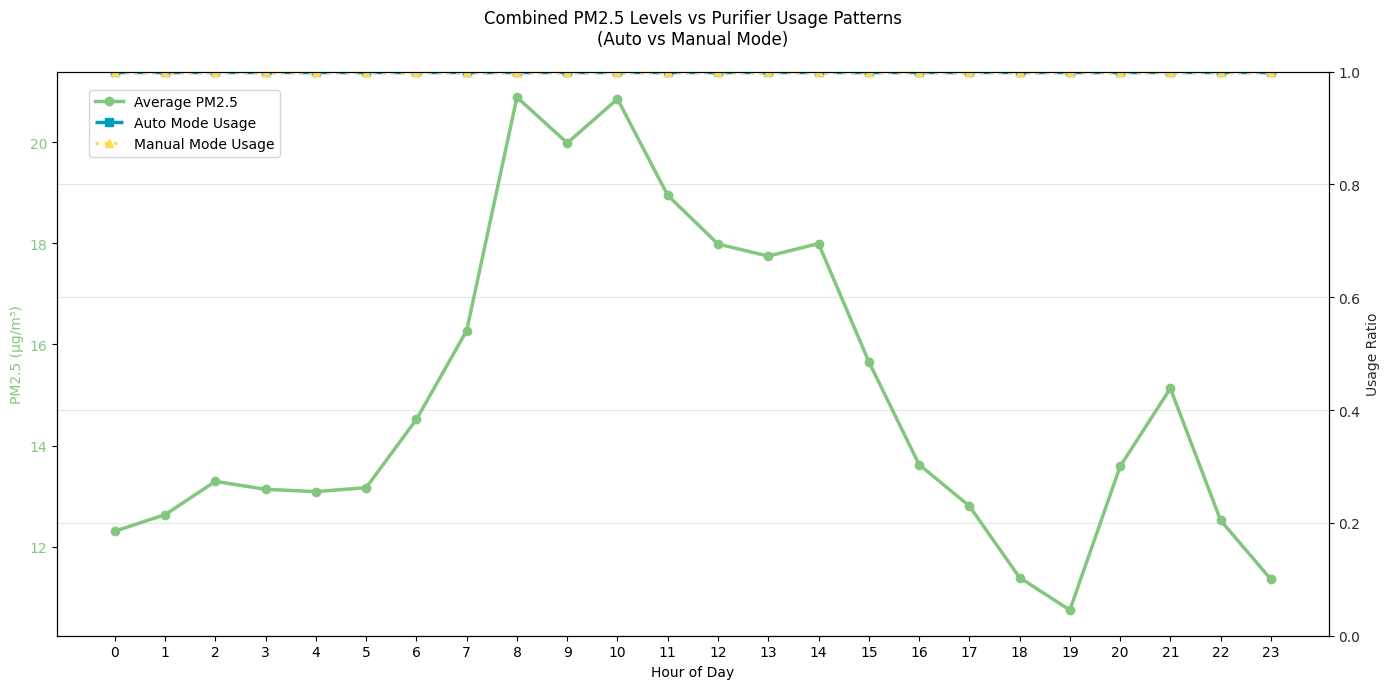

In [150]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming purifier_df and airtest_df are loaded DataFrames

# 1. Prepare Mode-Specific Usage Data
# -----------------------------------
# Filter and process purifier data
auto_usage = purifier_df[purifier_df['Mode'] == 'AUTO'].copy()
manual_usage = purifier_df[purifier_df['Mode'] == 'MANUAL'].copy()

# Calculate hourly averages
auto_usage['hour'] = pd.to_datetime(auto_usage['Timestamp']).dt.hour
auto_hourly = auto_usage.groupby('hour')['Power'].mean().reset_index()

manual_usage['hour'] = pd.to_datetime(manual_usage['Timestamp']).dt.hour
manual_hourly = manual_usage.groupby('hour')['Power'].mean().reset_index()

# 2. Prepare PM2.5 Data
# ---------------------
# Combine AirTest and purifier PM2.5 readings
pm25_data = pd.concat([
    airtest_df[['Timestamp', 'Pm25']],
    purifier_df[purifier_df['Pm25'].notnull()][['Timestamp', 'Pm25']]
])
# pm25_data = airtest_df[['Timestamp', 'Pm25']]

pm25_data['hour'] = pd.to_datetime(pm25_data['Timestamp']).dt.hour
pm25_hourly = pm25_data.groupby('hour')['Pm25'].mean().reset_index()

# 3. Create Combined Plot
# -----------------------
fig, ax1 = plt.subplots(figsize=(14,7))

# PM2.5 Plot (Primary Axis)
ax1.plot(pm25_hourly['hour'], pm25_hourly['Pm25'],
        color='#83c77f', linewidth=2.5, marker='o',
        label='Average PM2.5')
ax1.set_xlabel('Hour of Day')
ax1.set_ylabel('PM2.5 (μg/m³)', color='#83c77f')
ax1.tick_params(axis='y', labelcolor='#83c77f')
ax1.set_xticks(range(0,24))

# Usage Plot (Secondary Axis)
ax2 = ax1.twinx()
ax2.plot(auto_hourly['hour'], auto_hourly['Power'],
        color='#009FB7', linewidth=2.5, linestyle='--',
        marker='s', label='Auto Mode Usage')
ax2.plot(manual_hourly['hour'], manual_hourly['Power'],
        color='#FFD855', linewidth=2.5, linestyle=':',
        marker='^', label='Manual Mode Usage')
ax2.set_ylabel('Usage Ratio', color='#2a2a2a')
ax2.tick_params(axis='y', labelcolor='#2a2a2a')
ax2.set_ylim(0, 1)

# Formatting
plt.title('Combined PM2.5 Levels vs Purifier Usage Patterns\n(Auto vs Manual Mode)', pad=20)
plt.grid(alpha=0.3)

# Combined legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2,
         loc='upper left', bbox_to_anchor=(0.02, 0.98))

plt.tight_layout()
plt.show()


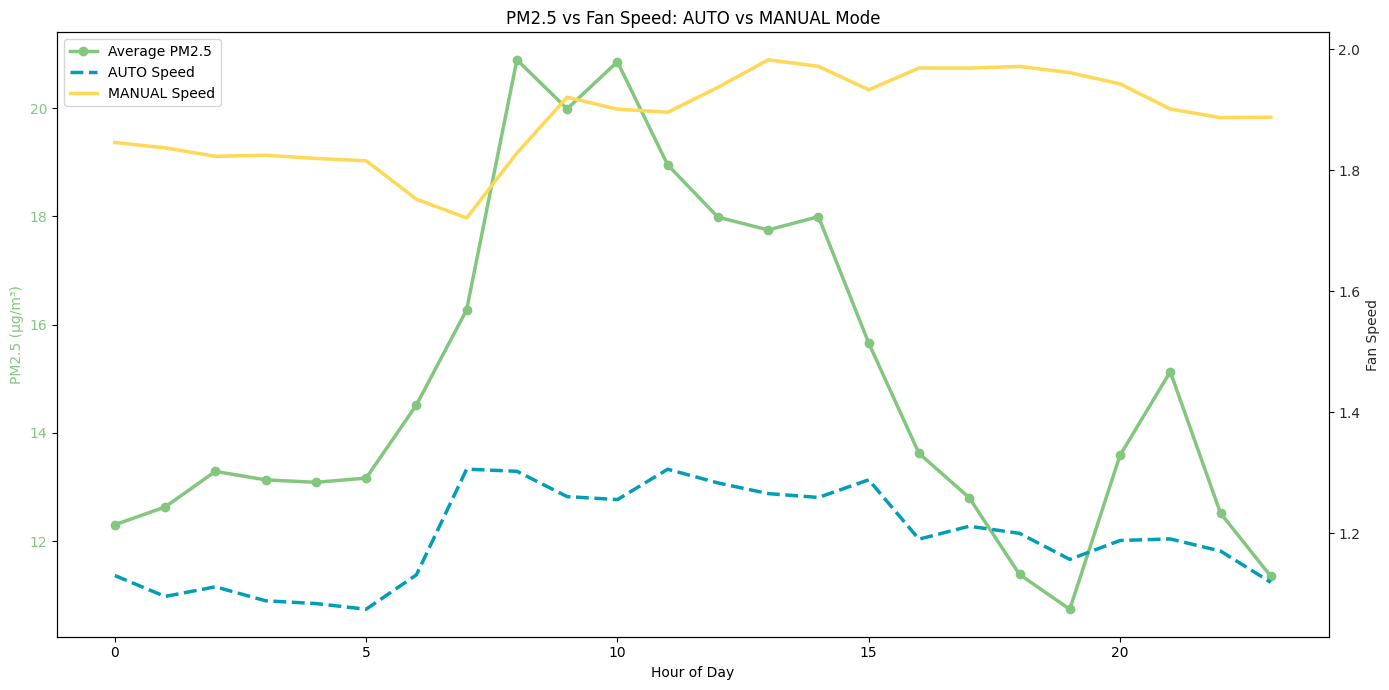

In [160]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare data (only use rows where device is ON)
auto_data = purifier_df[(purifier_df['Mode'] == 'AUTO') & (purifier_df['Power'] == 1)].copy()
manual_data = purifier_df[(purifier_df['Mode'] == 'MANUAL') & (purifier_df['Power'] == 1)].copy()

# Add hour column
auto_data['hour'] = pd.to_datetime(auto_data['Timestamp']).dt.hour
manual_data['hour'] = pd.to_datetime(manual_data['Timestamp']).dt.hour

# Calculate average speed by hour
auto_speed = auto_data.groupby('hour')['Speed'].mean().reset_index()
manual_speed = manual_data.groupby('hour')['Speed'].mean().reset_index()

# Plot with PM2.5
fig, ax1 = plt.subplots(figsize=(14,7))

# PM2.5 on primary axis
ax1.plot(pm25_hourly['hour'], pm25_hourly['Pm25'],
         color='#83c77f', linewidth=2.5, marker='o', label='Average PM2.5')
ax1.set_xlabel('Hour of Day')
ax1.set_ylabel('PM2.5 (μg/m³)', color='#83c77f')
ax1.tick_params(axis='y', labelcolor='#83c77f')

# Speed on secondary axis
ax2 = ax1.twinx()
ax2.plot(auto_speed['hour'], auto_speed['Speed'],
         color='#009FB7', linewidth=2.5, linestyle='--', label='AUTO Speed')
ax2.plot(manual_speed['hour'], manual_speed['Speed'],
         color='#FFD855', linewidth=2.5, linestyle='-', label='MANUAL Speed')
ax2.set_ylabel('Fan Speed', color='#2a2a2a')
ax2.tick_params(axis='y', labelcolor='#2a2a2a')

# Legend and formatting
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.title('PM2.5 vs Fan Speed: AUTO vs MANUAL Mode')
plt.tight_layout()
plt.show()


In [151]:
print(purifier_df['Mode'].value_counts())
print(purifier_df['Power'].value_counts())


Mode
OFF       327303
MANUAL    279738
AUTO      240181
Name: count, dtype: int64
Power
1    519919
0    327303
Name: count, dtype: Int64


Processing 1f8a0d...


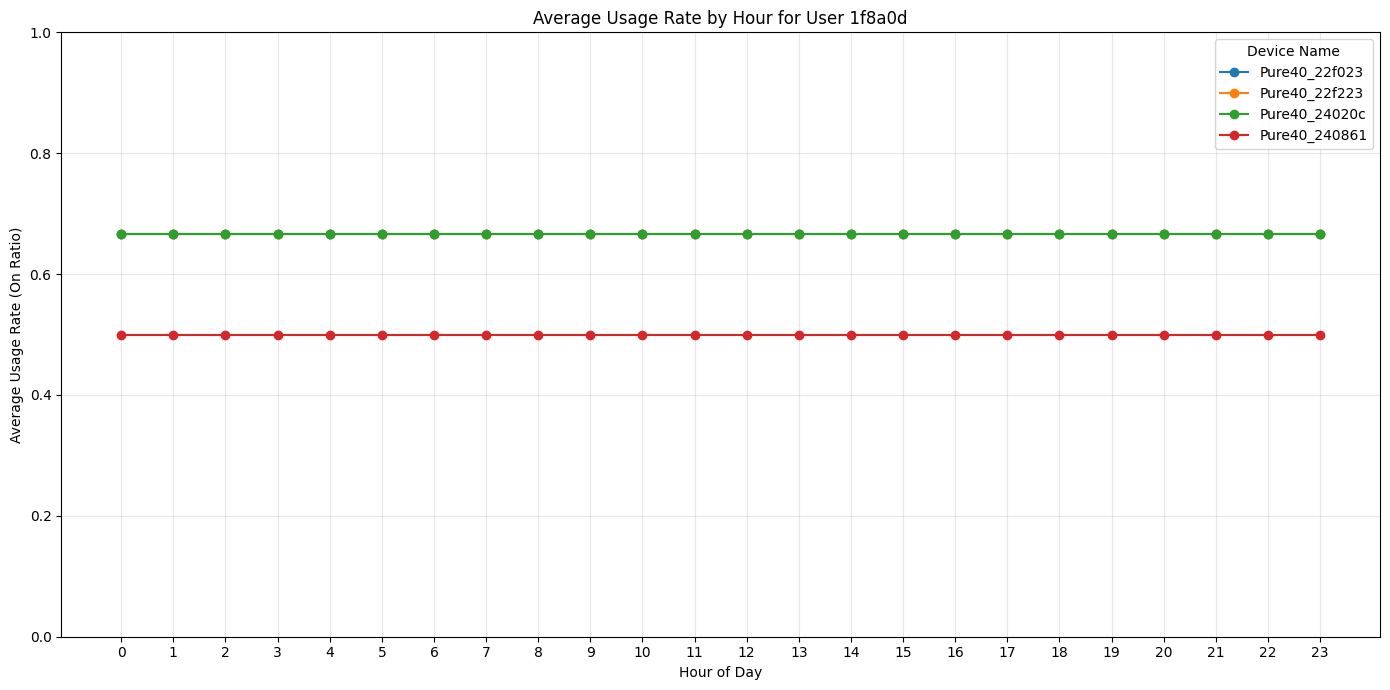

Processing 2e13b5...


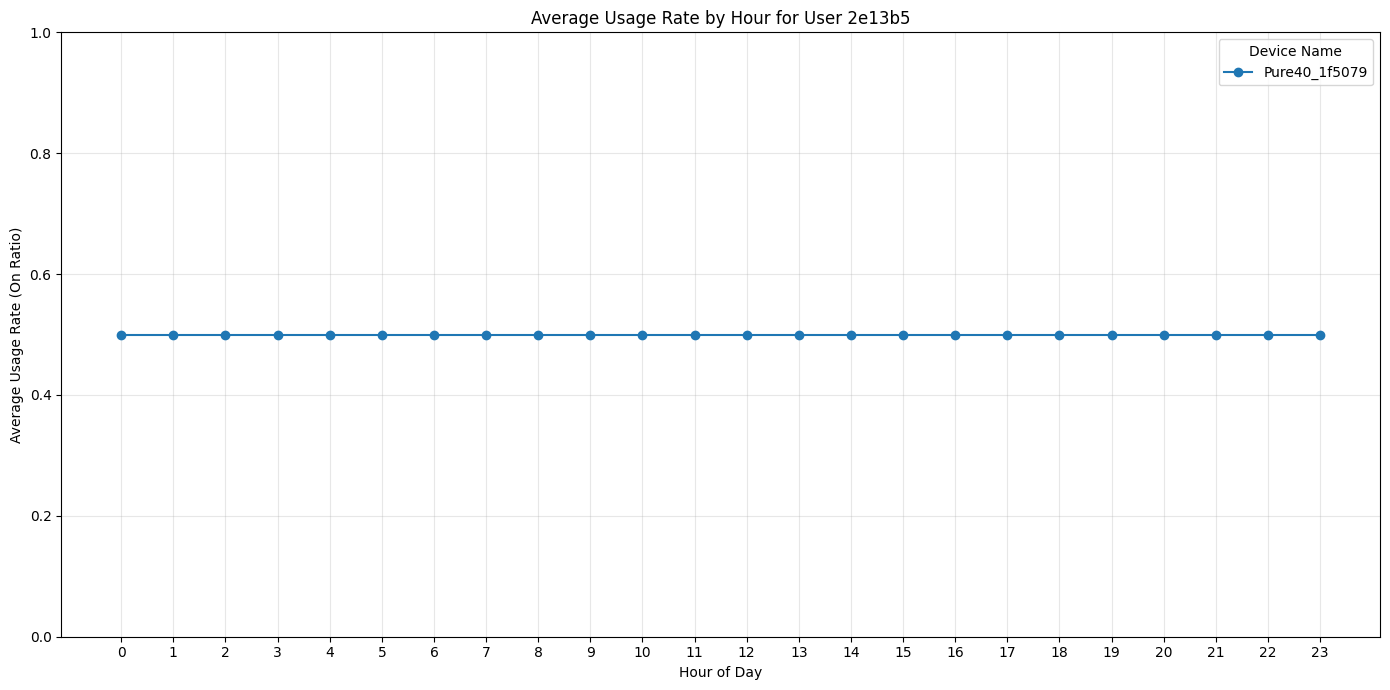

Processing 2f0449...


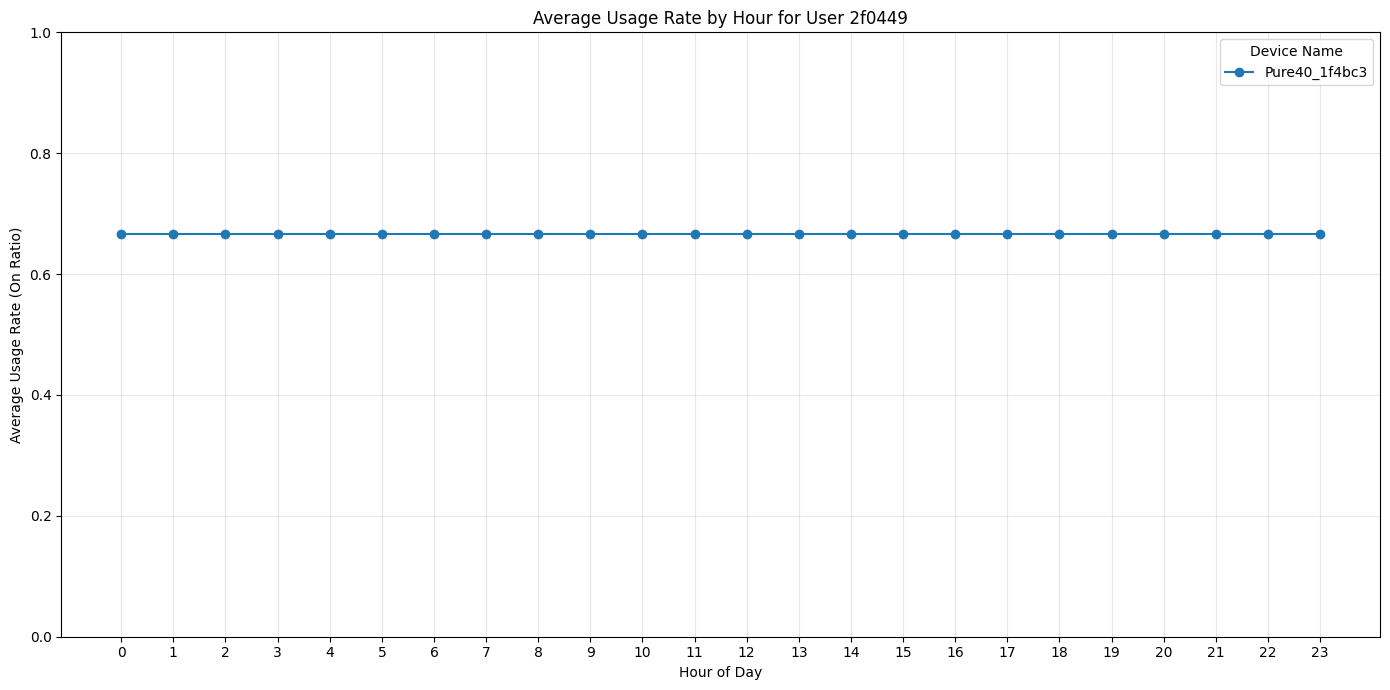

Processing 4c5f4c...


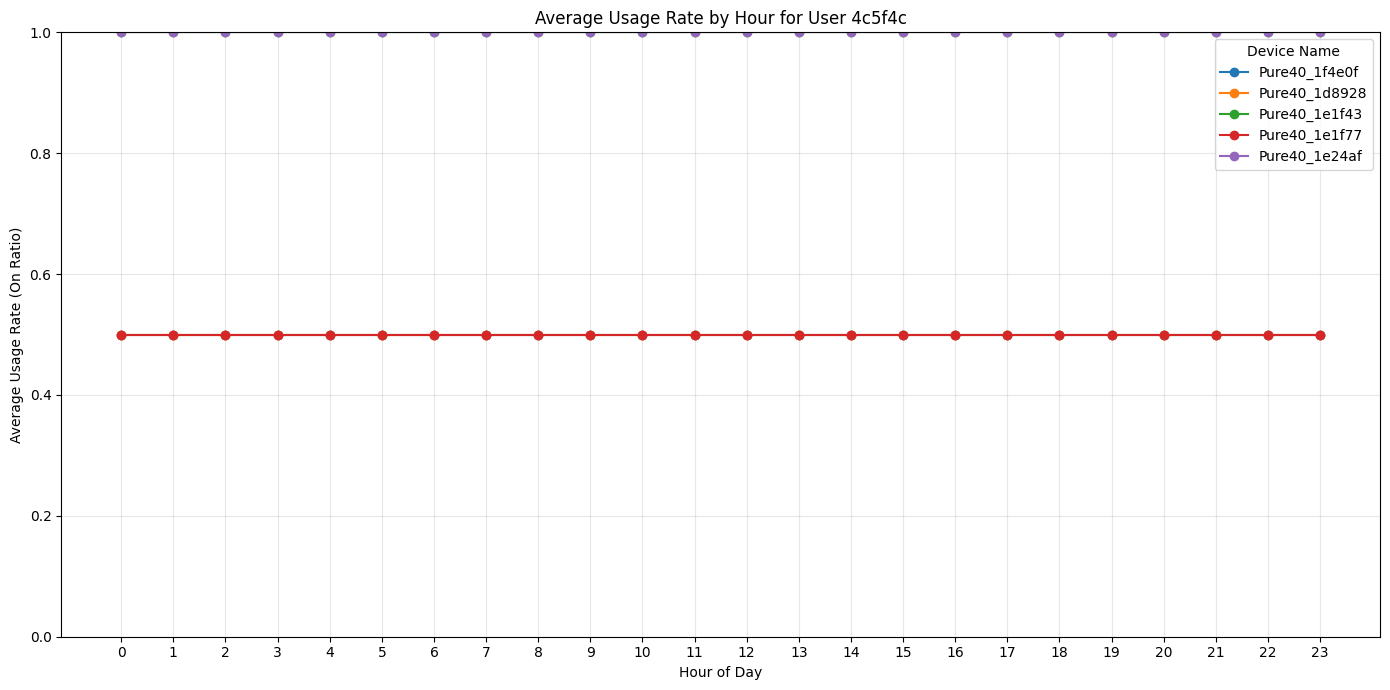

Processing 5ab22b...


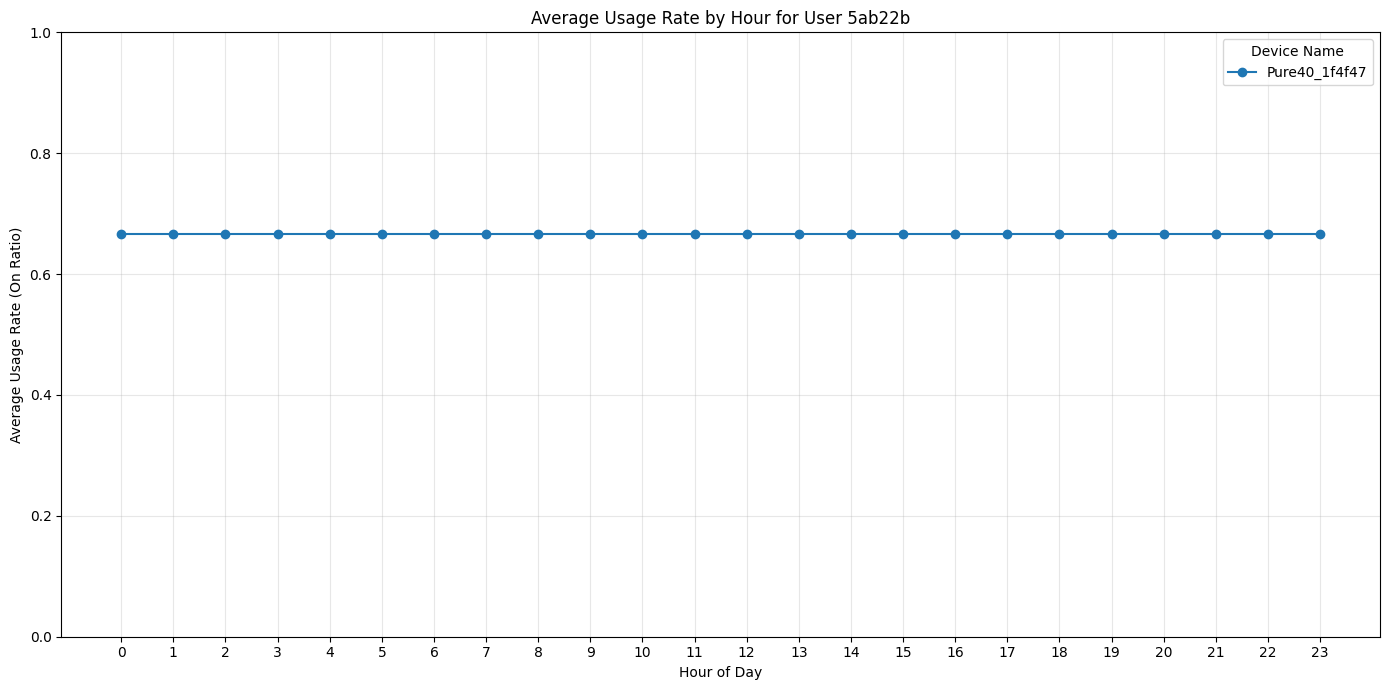

Processing 2dd893...


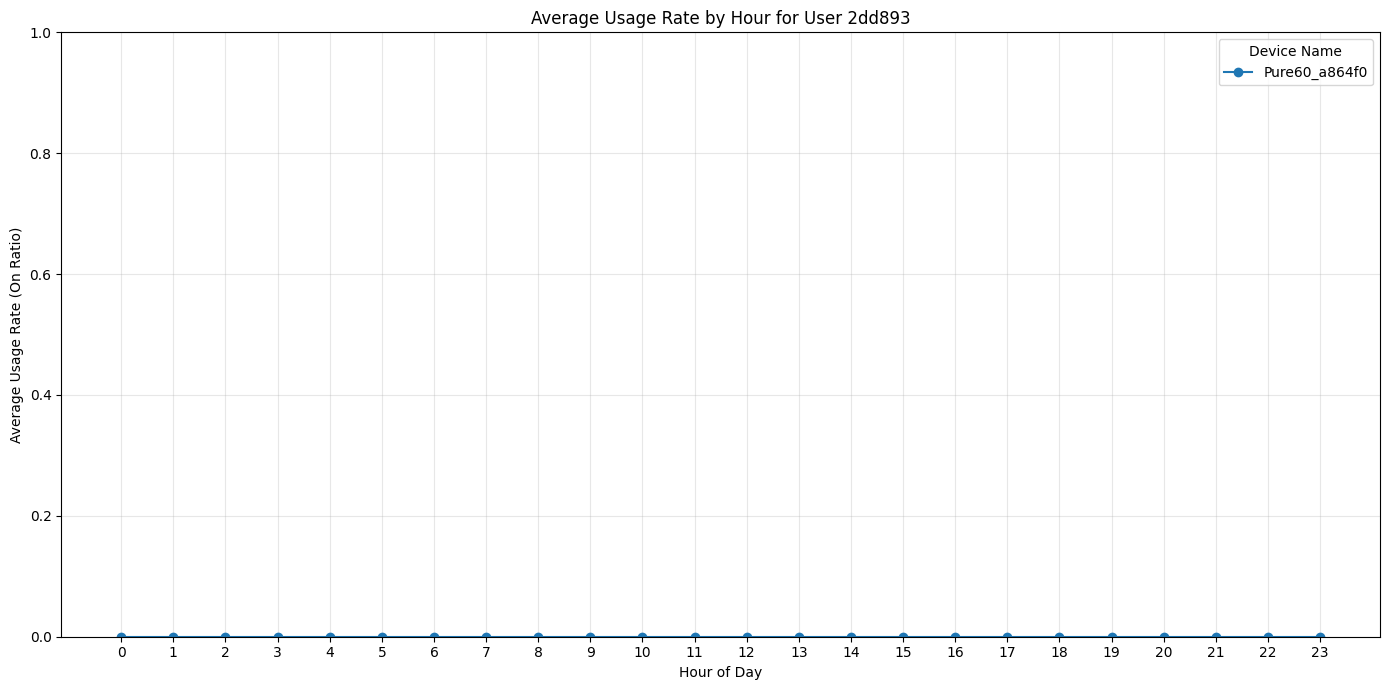

Processing 5d5c95...
No purifier data found for user 5d5c95ae-47d0-4194-b0d0-d2a29b6cd3f8


In [134]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_usage_by_mode_hourly(user_id, purifier_df):
    # Filter data for the user
    user_data = purifier_df[purifier_df['Uuid'] == user_id].copy()
    if user_data.empty:
        print(f"No purifier data found for user {user_id}")
        return

    # Convert Timestamp to datetime if not already
    user_data['Timestamp'] = pd.to_datetime(user_data['Timestamp'])

    # Extract hour of day
    user_data['hour'] = user_data['Timestamp'].dt.hour

    # Get unique device names
    device_names = user_data['Device Name'].unique()

    # Define colors for devices - one color per device
    colors = plt.cm.tab10(range(len(device_names)))

    # Define line styles and widths for modes - focus on clear distinction
    mode_linestyles = {'AUTO': 'dotted', 'MANUAL': 'solid', 'OFF': 'dashed'}
    mode_linewidths = {'AUTO': 2, 'MANUAL': 4, 'OFF': 1.5}  # Made MANUAL even thicker

    plt.figure(figsize=(14, 7))

    # Plot average usage for each device and mode
    for idx, device in enumerate(device_names):
        device_data = user_data[user_data['Device Name'] == device]
        device_color = colors[idx]

        for mode in sorted(device_data['Mode'].unique()):  # Sort modes to ensure consistent order
            mode_data = device_data[device_data['Mode'] == mode]
            hourly_usage = mode_data.groupby('hour')['Power'].mean().reset_index()

            plt.plot(hourly_usage['hour'], hourly_usage['Power'],
                     label=f"{device} - {mode}",
                     color=device_color,
                     linestyle=mode_linestyles.get(mode, 'solid'),
                     linewidth=mode_linewidths.get(mode, 2),
                     marker='o' if mode == 'AUTO' else 's')  # Different markers too

    plt.title(f"Hourly Purifier Usage by Mode for User {user_id[:6]}")
    plt.xlabel("Hour of Day")
    plt.ylabel("Average Usage Rate (On Ratio)")
    plt.xticks(range(0, 24))
    plt.ylim(0, 1)
    plt.legend(title="Device - Mode", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()




ids = ['1f8a0dd4-72c2-4ff4-bfb9-8b8ded756ec5',
       '2e13b5a2-99eb-4277-a51b-d37c765a0a2e',
       '2f04498d-3408-4bd9-a545-653364db22fa',
       '4c5f4c12-a85f-46e8-b075-b58e63b7bf71',
       '5ab22bb7-c837-4703-acf6-b9137820d670',
       '2dd89330-253f-4659-90cc-55ee33bcdb38',
       '5d5c95ae-47d0-4194-b0d0-d2a29b6cd3f8']
for id in ids:
    print(f"Processing {id[:6]}...")
    plot_usage_by_mode_hourly(id, purifier_df)

Processing 1f8a0d...


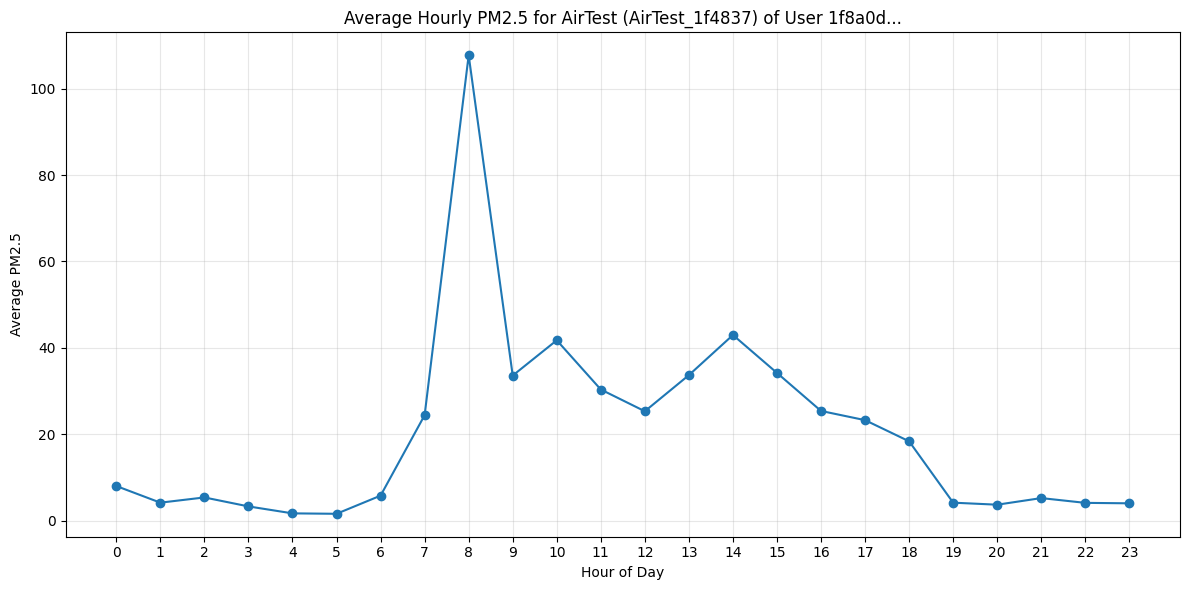

Processing 2e13b5...


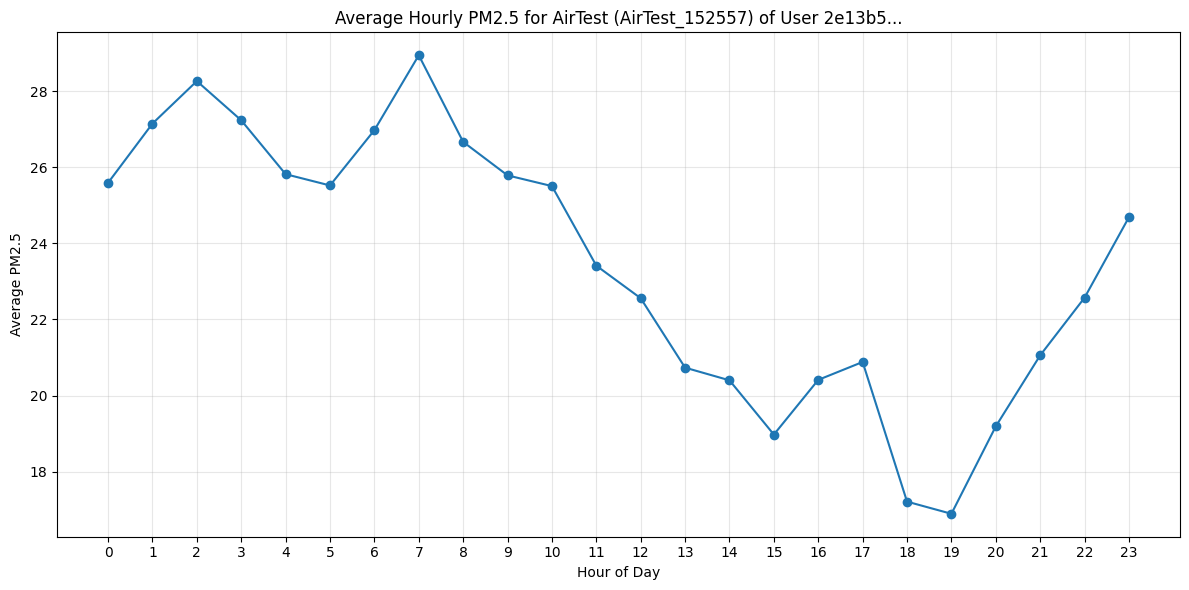

Processing 2f0449...


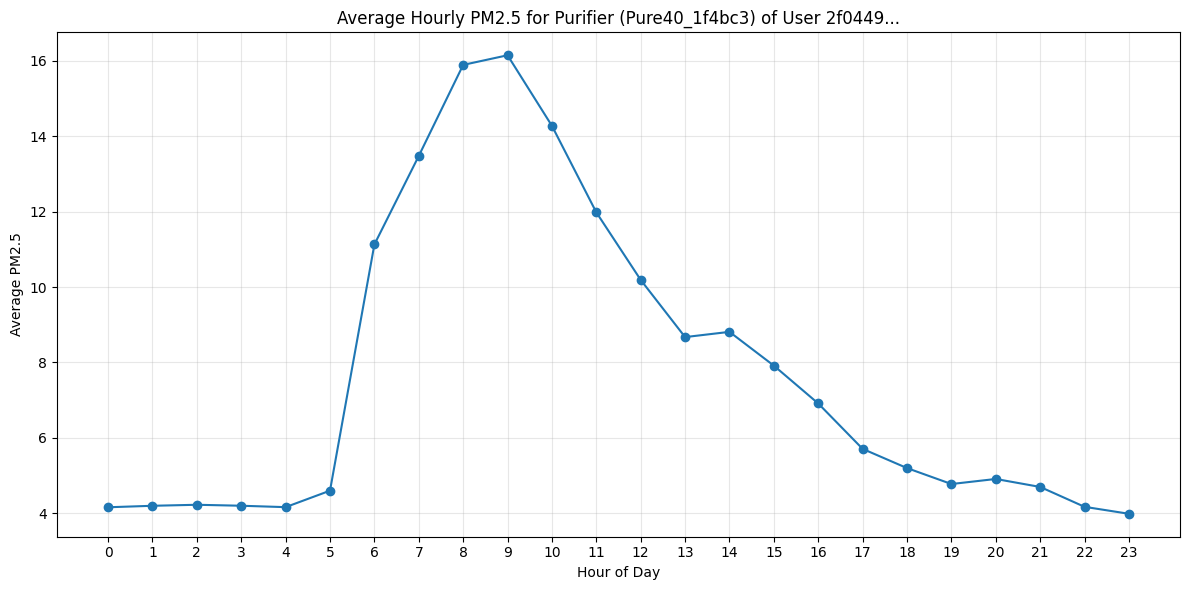

Processing 4c5f4c...


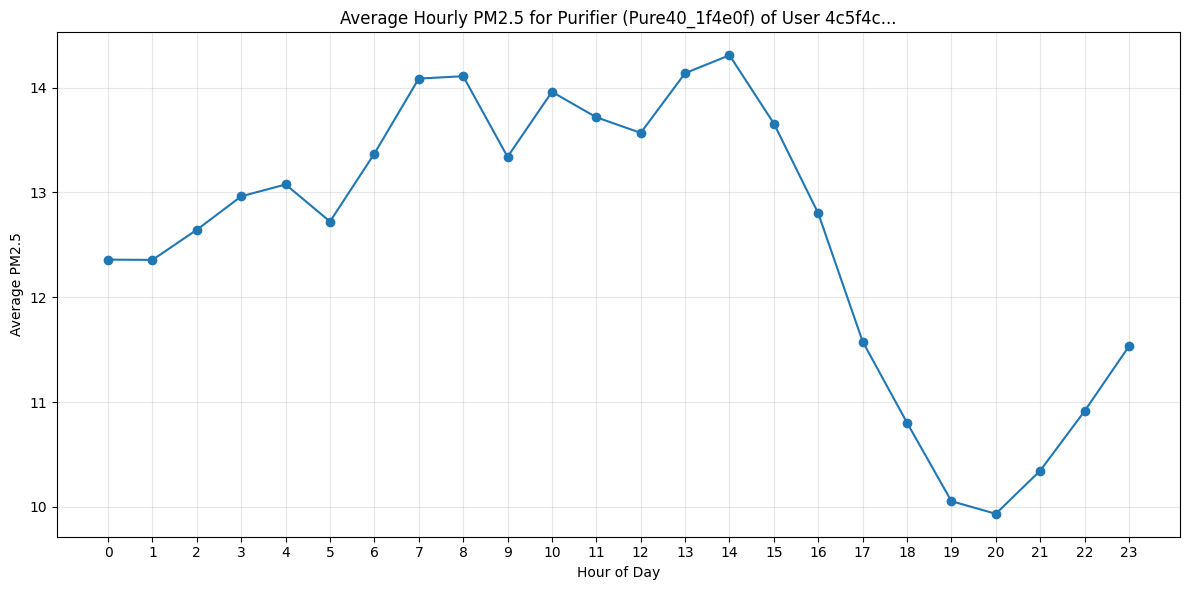

Processing 5ab22b...


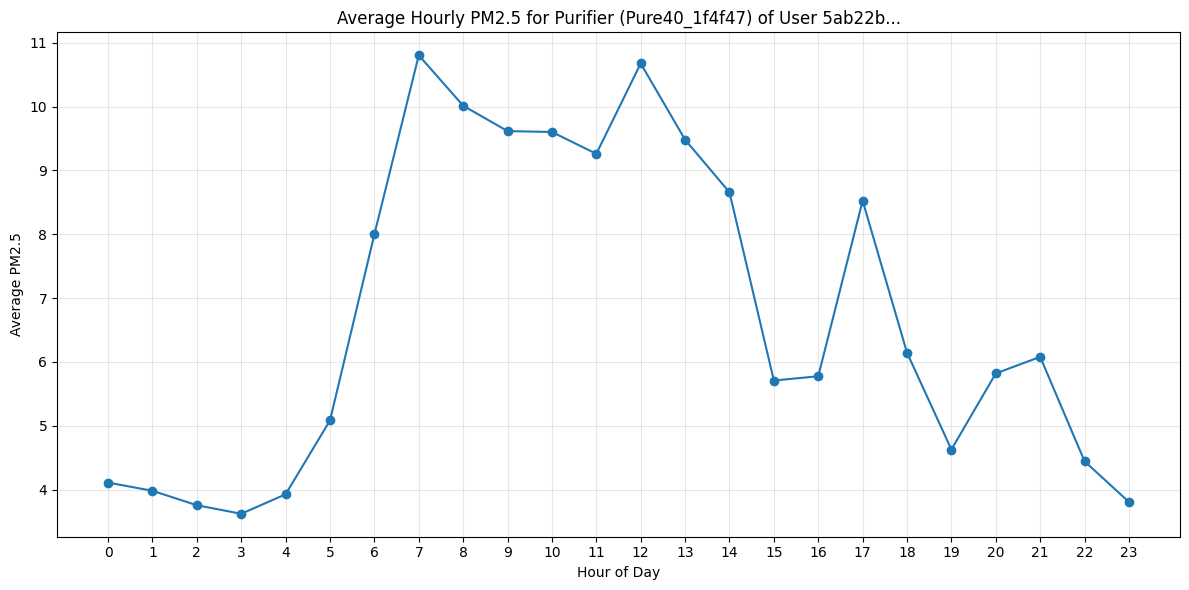

Processing 2dd893...


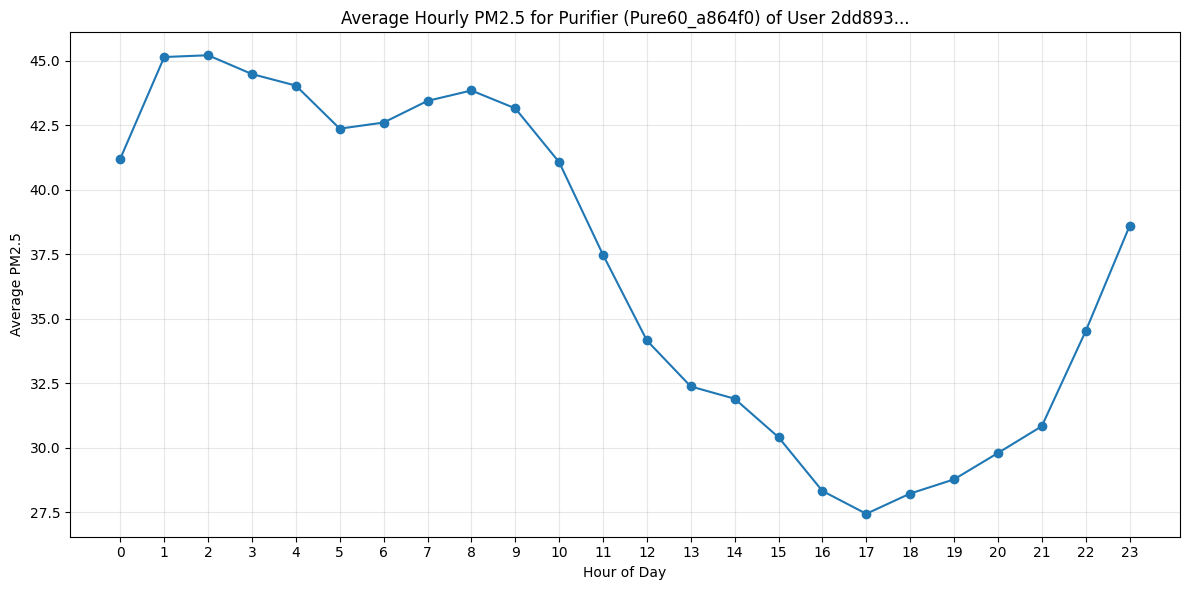

Processing 5d5c95...


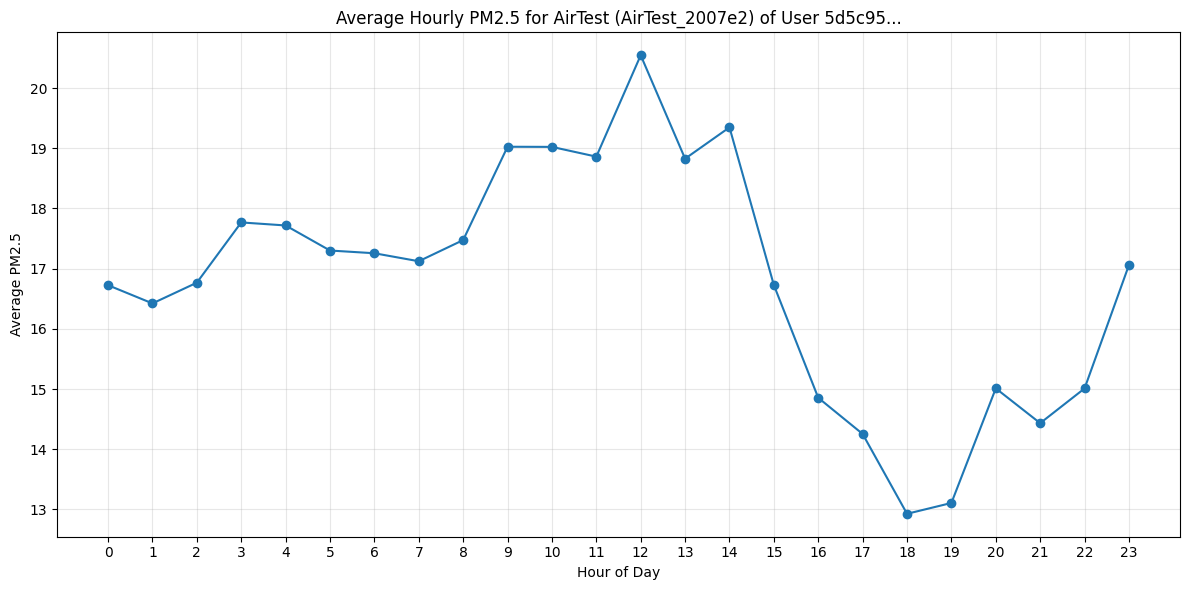

In [135]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_avg_hourly_pm25_for_user(user_id, purifier_df, airtest_df):
    # First, check if user has any AirTest device
    user_airtest = airtest_df[airtest_df['Uuid'] == user_id]
    if not user_airtest.empty:
        # Use the first AirTest device
        device_name = user_airtest['Device Name'].iloc[0]
        device_data = user_airtest[user_airtest['Device Name'] == device_name].copy()
        device_data['Timestamp'] = pd.to_datetime(device_data['Timestamp'])
        device_data['hour'] = device_data['Timestamp'].dt.hour
        hourly_pm25_avg = device_data.groupby('hour')['Pm25'].mean().reset_index()
        source = f"AirTest ({device_name})"
    else:
        # Use purifier PM2.5 if available
        user_purifier = purifier_df[purifier_df['Uuid'] == user_id]
        if 'Pm25' in user_purifier.columns and user_purifier['Pm25'].notnull().sum() > 5:
            device_name = user_purifier['Device Name'].iloc[0]
            device_data = user_purifier[user_purifier['Device Name'] == device_name].copy()
            device_data['Timestamp'] = pd.to_datetime(device_data['Timestamp'])
            device_data['hour'] = device_data['Timestamp'].dt.hour
            hourly_pm25_avg = device_data.groupby('hour')['Pm25'].mean().reset_index()
            source = f"Purifier ({device_name})"
        else:
            print(f"No PM2.5 data available for user {user_id[:6]}...")
            return

    # Plot
    plt.figure(figsize=(12,6))
    plt.plot(hourly_pm25_avg['hour'], hourly_pm25_avg['Pm25'], marker='o', linestyle='-')
    plt.title(f'Average Hourly PM2.5 for {source} of User {user_id[:6]}...')
    plt.xlabel('Hour of Day')
    plt.ylabel('Average PM2.5')
    plt.xticks(range(0,24))
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

ids = ['1f8a0dd4-72c2-4ff4-bfb9-8b8ded756ec5',
       '2e13b5a2-99eb-4277-a51b-d37c765a0a2e',
       '2f04498d-3408-4bd9-a545-653364db22fa',
       '4c5f4c12-a85f-46e8-b075-b58e63b7bf71',
       '5ab22bb7-c837-4703-acf6-b9137820d670',
       '2dd89330-253f-4659-90cc-55ee33bcdb38',
       '5d5c95ae-47d0-4194-b0d0-d2a29b6cd3f8']
for id in ids:
    print(f"Processing {id[:6]}...")
    plot_avg_hourly_pm25_for_user(id, purifier_df, airtest_df)


In [136]:
# Check how many AirTest devices this user has
user_id = '2e13b5a2-99eb-4277-a51b-d37c765a0a2e'  # Replace with actual full user ID
user_airtest = airtest_df[airtest_df['Uuid'] == user_id].copy()
print(f"Number of AirTest devices: {user_airtest['Device Name'].nunique()}")
print(f"Device names: {user_airtest['Device Name'].unique()}")

# Compare PM2.5 values across devices at same timestamps
pivot_df = user_airtest.pivot_table(index='Timestamp',
                                    columns='Device Name',
                                    values='Pm25')

# Calculate correlation between devices
corr_matrix = pivot_df.corr()
print("\nCorrelation between devices:")
print(corr_matrix)

# Calculate average difference between devices
from itertools import combinations
import numpy as np

diffs = []
for ts, row in pivot_df.iterrows():
    values = row.dropna()
    if len(values) > 1:
        device_pairs = list(combinations(values.index, 2))
        for (d1, d2) in device_pairs:
            diffs.append(abs(values[d1] - values[d2]))

mean_diff = np.mean(diffs) if diffs else None
print(f"\nAverage absolute difference between devices: {mean_diff:.2f} μg/m³")


Number of AirTest devices: 4
Device names: ['AirTest_152557' 'AirTest_200178' 'AirTest_1f4fa3' 'AirTest_2005cc']

Correlation between devices:
Device Name     AirTest_152557  AirTest_1f4fa3  AirTest_200178  AirTest_2005cc
Device Name                                                                   
AirTest_152557        1.000000        0.744478        0.787365        0.562938
AirTest_1f4fa3        0.744478        1.000000        0.831993        0.492148
AirTest_200178        0.787365        0.831993        1.000000        0.631089
AirTest_2005cc        0.562938        0.492148        0.631089        1.000000

Average absolute difference between devices: 8.25 μg/m³


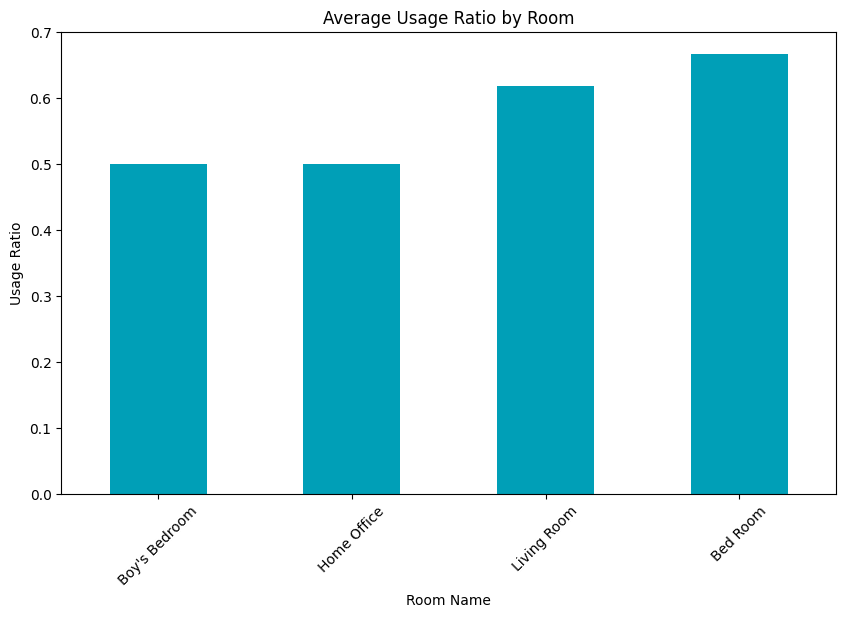

In [161]:
# Assuming 'room' is a column in your purifier_df
room_usage = purifier_df.groupby('Room Name')['Power'].mean().sort_values()
plt.figure(figsize=(10,6))
room_usage.plot(kind='bar', color='#009FB7')
plt.title('Average Usage Ratio by Room')
plt.ylabel('Usage Ratio')
plt.xticks(rotation=45)
plt.show()


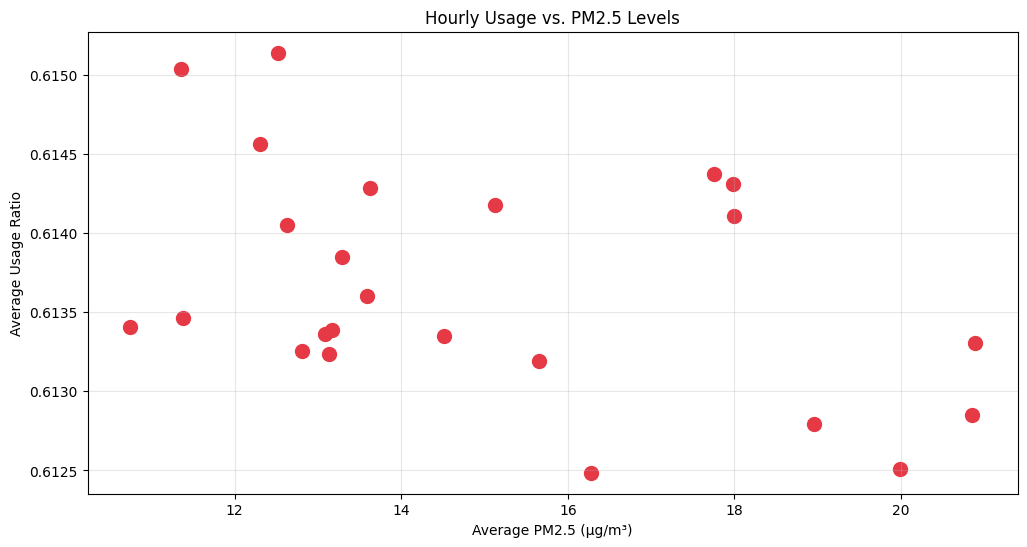

In [162]:
# Merge PM2.5 and usage data by hour
hourly_pm25 = pm25_data.groupby(pd.to_datetime(pm25_data['Timestamp']).dt.hour)['Pm25'].mean()
hourly_usage = purifier_df.groupby(pd.to_datetime(purifier_df['Timestamp']).dt.hour)['Power'].mean()

# Plot correlation
plt.figure(figsize=(12,6))
plt.scatter(hourly_pm25, hourly_usage, c='#e63946', s=100)
plt.xlabel('Average PM2.5 (μg/m³)')
plt.ylabel('Average Usage Ratio')
plt.title('Hourly Usage vs. PM2.5 Levels')
plt.grid(alpha=0.3)


Text(0, 0.5, 'Usage Ratio')

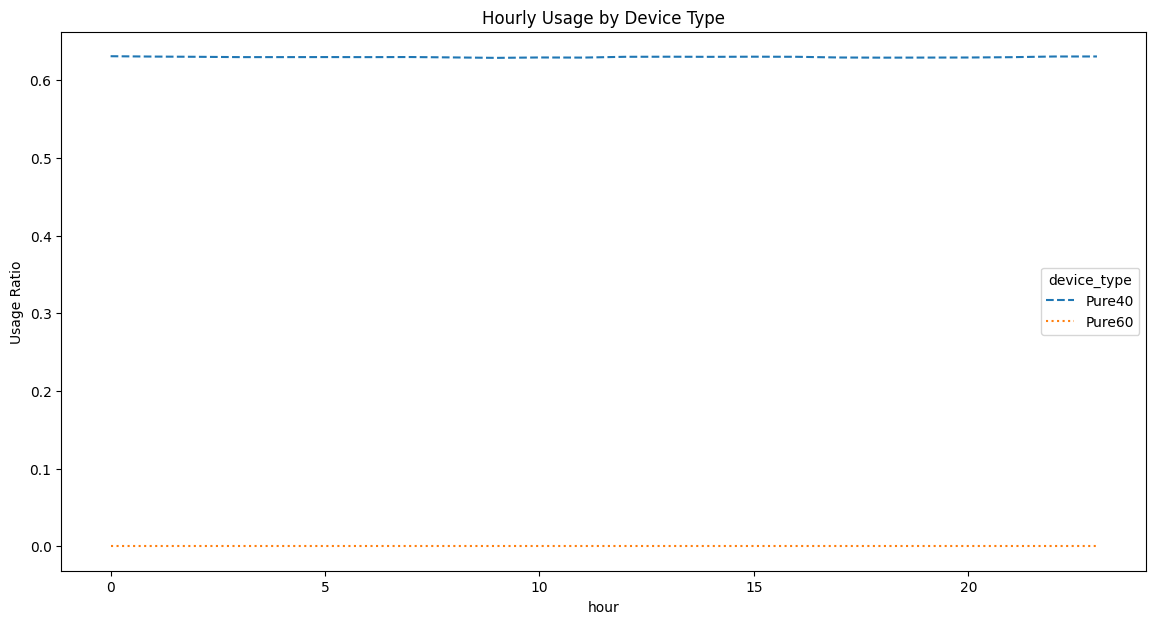

In [163]:
device_usage = purifier_df.groupby(['device_type', 'hour'])['Power'].mean().unstack(0)
device_usage.plot(figsize=(14,7), style={'Pure40': '--', 'Pure60': ':'})
plt.title('Hourly Usage by Device Type')
plt.ylabel('Usage Ratio')


                                  index  avg_on_ratio  pct_mode_auto  \
0  1f8a0dd4-72c2-4ff4-bfb9-8b8ded756ec5      0.636529       0.363471   
1  2dd89330-253f-4659-90cc-55ee33bcdb38           0.0       0.000000   
2  2e13b5a2-99eb-4277-a51b-d37c765a0a2e           0.5       0.000000   
3  2f04498d-3408-4bd9-a545-653364db22fa      0.666667       0.333333   
4  4c5f4c12-a85f-46e8-b075-b58e63b7bf71      0.630332       0.211195   

   pct_mode_manual  pct_mode_off   avg_pm25  avg_speed  night_usage  \
0         0.273059      0.363471  13.638894   1.531519     0.636807   
1         0.000000      1.000000  37.298874   0.000000          0.0   
2         0.500000      0.500000  23.135464   0.002882          0.5   
3         0.333333      0.333333   7.602086   0.733400     0.666667   
4         0.419137      0.369668   5.714101   0.483373     0.629693   

   day_usage  num_rooms  
0   0.636392          0  
1        0.0          0  
2        0.5          0  
3   0.666667          0  
4   0.6306

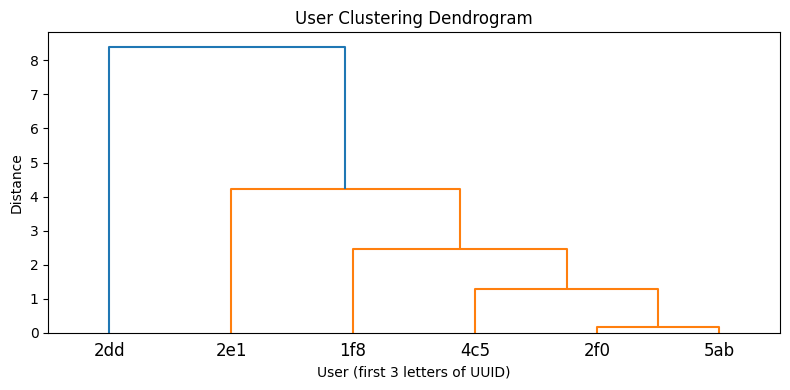

                                  index  Cluster
0  1f8a0dd4-72c2-4ff4-bfb9-8b8ded756ec5        1
1  2dd89330-253f-4659-90cc-55ee33bcdb38        3
2  2e13b5a2-99eb-4277-a51b-d37c765a0a2e        2
3  2f04498d-3408-4bd9-a545-653364db22fa        1
4  4c5f4c12-a85f-46e8-b075-b58e63b7bf71        1
5  5ab22bb7-c837-4703-acf6-b9137820d670        1


In [177]:
### CLUSTERING

import pandas as pd
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt
import pandas as pd

# Ensure Timestamp columns are datetime
purifier_df['Timestamp'] = pd.to_datetime(purifier_df['Timestamp'])
airtest_df['Timestamp'] = pd.to_datetime(airtest_df['Timestamp'])

# Define nighttime hours (10pm-6am)
night_hours = list(range(22,24)) + list(range(0,6))

# 1. Average ON ratio per user
user_on_ratio = purifier_df.groupby('Uuid')['Power'].mean().rename('avg_on_ratio')

# 2. Mode percentages per user
mode_counts = purifier_df.groupby(['Uuid', 'Mode']).size().unstack(fill_value=0)
mode_percent = mode_counts.div(mode_counts.sum(axis=1), axis=0).rename(columns=lambda x: f"pct_mode_{x.lower()}")

# 3. Average PM2.5 per user (combining AirTest and purifier PM2.5)
def get_user_avg_pm25(user_id):
    airtest_pm25 = airtest_df[airtest_df['Uuid'] == user_id]['Pm25']
    purifier_pm25 = purifier_df[(purifier_df['Uuid'] == user_id) & purifier_df['Pm25'].notnull()]['Pm25']
    combined = pd.concat([airtest_pm25, purifier_pm25])
    if len(combined) == 0:
        return None
    return combined.mean()

user_pm25 = pd.Series({user: get_user_avg_pm25(user) for user in purifier_df['Uuid'].unique()}).rename('avg_pm25')

# 4. Average fan speed per user
user_avg_speed = purifier_df.groupby('Uuid')['Speed'].mean().rename('avg_speed')

# 5. Nighttime and daytime usage ratio per user
purifier_df['hour'] = purifier_df['Timestamp'].dt.hour
night_usage = purifier_df[purifier_df['hour'].isin(night_hours)].groupby('Uuid')['Power'].mean().rename('night_usage')
day_usage = purifier_df[~purifier_df['hour'].isin(night_hours)].groupby('Uuid')['Power'].mean().rename('day_usage')

# 6. Number of unique rooms per user (if available)
if 'room' in purifier_df.columns:
    user_room_count = purifier_df.groupby('Uuid')['room'].nunique().rename('num_rooms')
else:
    user_room_count = pd.Series(0, index=purifier_df['Uuid'].unique(), name='num_rooms')

# Combine all features into one DataFrame
user_feature_df = pd.concat([
    user_on_ratio,
    mode_percent,
    user_pm25,
    user_avg_speed,
    night_usage,
    day_usage,
    user_room_count
], axis=1)

# Fill NaN values with 0 for features where appropriate
user_feature_df.fillna(0, inplace=True)

# Reset index to have 'User' column
user_feature_df.reset_index(inplace=True)
user_feature_df.rename(columns={'Uuid': 'User'}, inplace=True)

# Show the first few rows
print(user_feature_df.head())

features = user_feature_df.drop('index', axis=1).values

# Standardize features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Perform hierarchical clustering
linked = linkage(features_scaled, method='ward')

# Prepare x-axis labels as first 3 letters of UUID
user_labels = user_feature_df['index'].tolist()
x_labels = [label[:3] for label in user_labels]

# Plot dendrogram
plt.figure(figsize=(8, 4))
dendrogram(linked, labels=x_labels)
plt.title('User Clustering Dendrogram')
plt.xlabel('User (first 3 letters of UUID)')
plt.ylabel('Distance')
plt.tight_layout()
plt.show()

# 4. Decide number of clusters (e.g., 2 or 3)
n_clusters = 3
clusters = fcluster(linked, n_clusters, criterion='maxclust')
user_feature_df['Cluster'] = clusters
print(user_feature_df[['index', 'Cluster']])


PM2.5 stats: min=0.0, 25%=2.0, median=7.0, 75%=20.0, max=2000.0
Using thresholds based on actual data: Lower=2.0, Upper=20.0


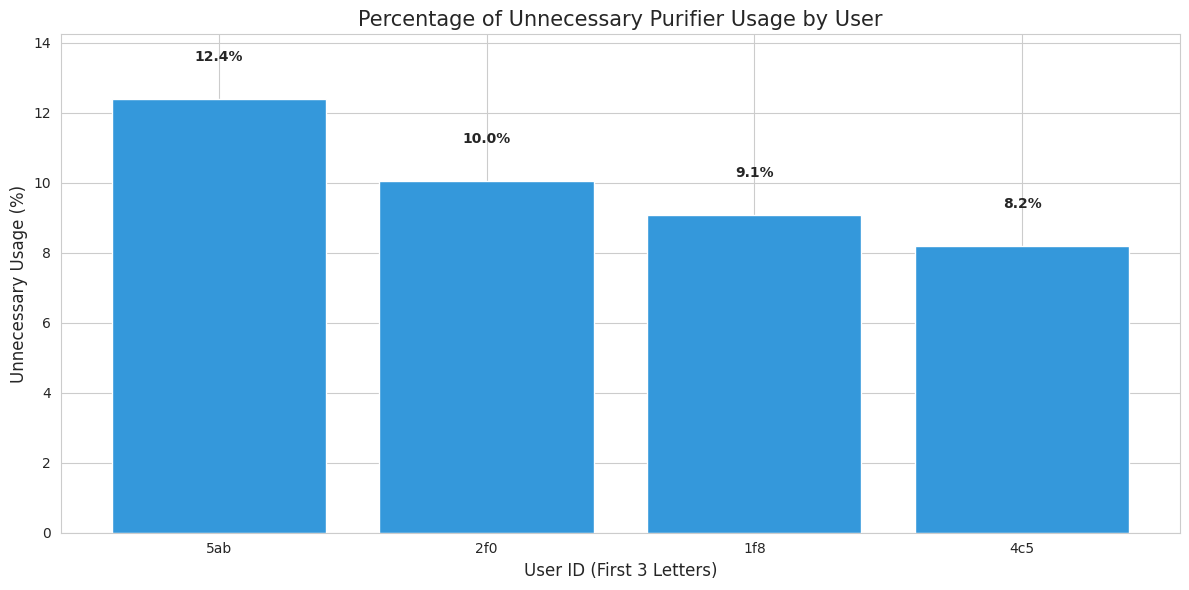

In [180]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure Timestamp is datetime
purifier_df['Timestamp'] = pd.to_datetime(purifier_df['Timestamp'])
airtest_df['Timestamp'] = pd.to_datetime(airtest_df['Timestamp'])

# First, get actual PM2.5 range stats to set reasonable thresholds
pm25_values = []
if 'Pm25' in airtest_df.columns:
    pm25_values.extend(airtest_df['Pm25'].dropna().tolist())
if 'Pm25' in purifier_df.columns:
    pm25_values.extend(purifier_df['Pm25'].dropna().tolist())

# Print actual PM2.5 stats
pm25_array = np.array(pm25_values)
print(f"PM2.5 stats: min={pm25_array.min():.1f}, 25%={np.percentile(pm25_array, 25):.1f}, "
      f"median={np.median(pm25_array):.1f}, 75%={np.percentile(pm25_array, 75):.1f}, max={pm25_array.max():.1f}")

# Set reasonable thresholds based on percentiles
lower_threshold = np.percentile(pm25_array, 25)  # 25th percentile
upper_threshold = np.percentile(pm25_array, 75)  # 75th percentile

print(f"Using thresholds based on actual data: Lower={lower_threshold:.1f}, Upper={upper_threshold:.1f}")

# Aggregate hourly data
purifier_hourly = purifier_df.groupby(['Uuid', pd.to_datetime(purifier_df['Timestamp']).dt.floor('h')]).agg(
    Power=('Power', 'mean'),
    Speed=('Speed', 'mean'),
    Mode=('Mode', lambda x: x.value_counts().index[0] if len(x) > 0 else None)
).reset_index()

# Combine PM2.5 data
pm25_hourly = pd.concat([
    airtest_df.groupby(['Uuid', pd.to_datetime(airtest_df['Timestamp']).dt.floor('h')])['Pm25'].mean().reset_index(),
    purifier_df[purifier_df['Pm25'].notnull()].groupby(['Uuid', pd.to_datetime(purifier_df['Timestamp']).dt.floor('h')])['Pm25'].mean().reset_index()
])
pm25_hourly.columns = ['Uuid', 'Timestamp', 'Pm25']

# Merge usage with PM2.5
usage_pm25 = pd.merge(purifier_hourly, pm25_hourly, on=['Uuid', 'Timestamp'], how='left')

# Define unnecessary usage conditions
usage_pm25['unnecessary_usage'] = 'Necessary'
usage_pm25.loc[(usage_pm25['Power'] > 0.5) & (usage_pm25['Pm25'] < lower_threshold), 'unnecessary_usage'] = 'Unnecessary - Low PM2.5'
usage_pm25.loc[(usage_pm25['Power'] > 0.5) & (usage_pm25['Speed'] >= 3) &
               (usage_pm25['Pm25'] >= lower_threshold) & (usage_pm25['Pm25'] < upper_threshold),
               'unnecessary_usage'] = 'Unnecessary - Too Fast'

# Calculate summary (without cost estimates)
summary_data = []
for uuid in usage_pm25['Uuid'].unique():
    user_data = usage_pm25[usage_pm25['Uuid'] == uuid]
    user_on_data = user_data[user_data['Power'] > 0.5]

    if len(user_on_data) == 0:
        continue

    unnecessary = user_on_data[user_on_data['unnecessary_usage'] != 'Necessary']
    unnecessary_pct = len(unnecessary) / len(user_on_data) * 100 if len(user_on_data) > 0 else 0

    low_pm25 = user_on_data[user_on_data['unnecessary_usage'] == 'Unnecessary - Low PM2.5']
    too_fast = user_on_data[user_on_data['unnecessary_usage'] == 'Unnecessary - Too Fast']

    summary_data.append({
        'Uuid': uuid,
        'Total Hours On': len(user_on_data),
        'Unnecessary Hours': len(unnecessary),
        'Low PM2.5 Hours': len(low_pm25),
        'Too Fast Hours': len(too_fast),
        'Unnecessary %': unnecessary_pct
    })

usage_summary = pd.DataFrame(summary_data).sort_values('Unnecessary %', ascending=False)

# PLOT: Percentage of Unnecessary Usage by User
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

# Shortening UUIDs for display
usage_summary['ShortID'] = usage_summary['Uuid'].str[:3]

# Create the bar chart
bars = plt.bar(usage_summary['ShortID'], usage_summary['Unnecessary %'], color='#3498db')

# Add data labels on top of bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 1,
             f'{usage_summary["Unnecessary %"].iloc[i]:.1f}%',
             ha='center', va='bottom', fontweight='bold')

plt.title('Percentage of Unnecessary Purifier Usage by User', fontsize=15)
plt.xlabel('User ID (First 3 Letters)', fontsize=12)
plt.ylabel('Unnecessary Usage (%)', fontsize=12)
plt.ylim(0, max(usage_summary['Unnecessary %']) * 1.15)  # Add some space for labels
plt.tight_layout()
plt.show()


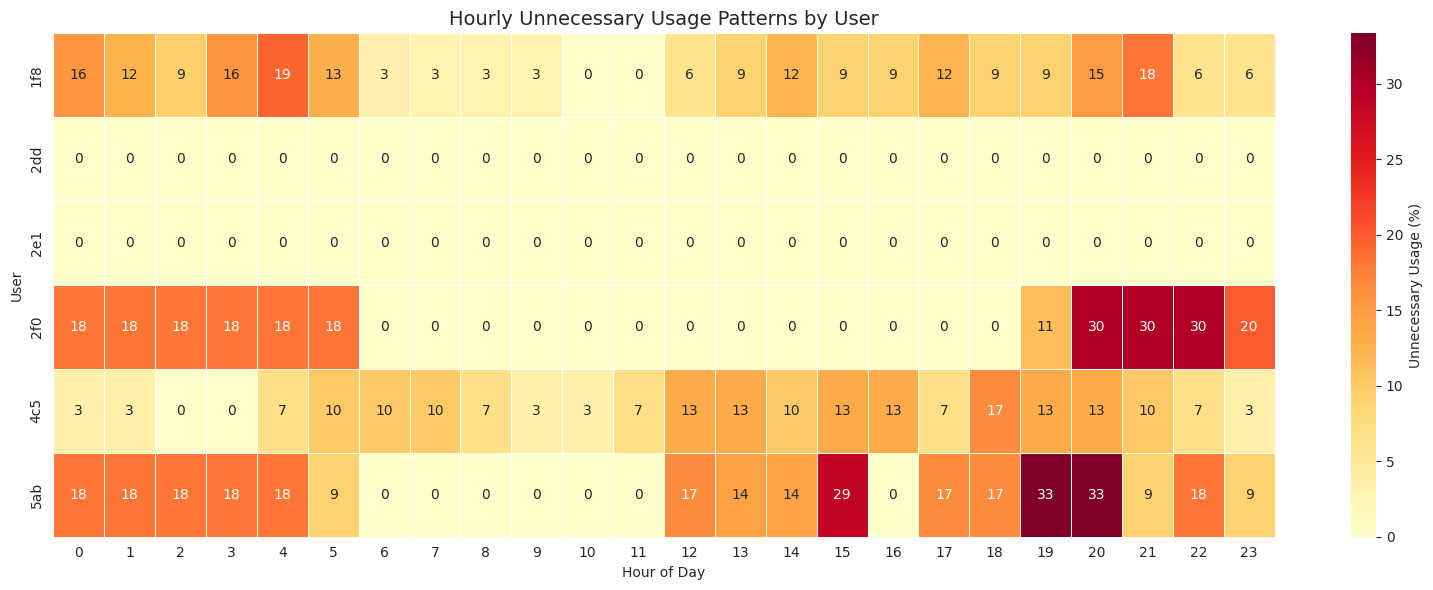

In [181]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# First, compute the unnecessary usage by hour for each user
hourly_unnecessary = usage_pm25.groupby(['Uuid', usage_pm25['Timestamp'].dt.hour])['unnecessary_usage'].apply(
    lambda x: (x != 'Necessary').sum() / len(x) * 100 if len(x) > 0 else 0
).reset_index()
hourly_unnecessary.columns = ['Uuid', 'Hour', 'Unnecessary %']

# Create a pivot table for the heatmap
heatmap_data = hourly_unnecessary.pivot(index='Uuid', columns='Hour', values='Unnecessary %')

# Replace UUID with shorter labels (first 3 characters)
heatmap_data.index = [idx[:3] for idx in heatmap_data.index]

# Create the heatmap
plt.figure(figsize=(16, 6))
sns.heatmap(heatmap_data, cmap='YlOrRd', annot=True, fmt='.0f',
            linewidths=0.5, cbar_kws={'label': 'Unnecessary Usage (%)'})
plt.title('Hourly Unnecessary Usage Patterns by User', fontsize=14)
plt.xlabel('Hour of Day')
plt.ylabel('User')
plt.tight_layout()
plt.show()
